In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Mixtures of GPs 

This notebook was made with the following version of george:

In [2]:
import george
george.__version__

'0.3.1'

It can be useful to model a dataset using a mixture of GPs.
For example, the data might have both systematic effects and a physical signal that can be modeled using a GP.
I konw of a few examples where this method has been used in the context of time series analysis for the discovery of transiting exoplanets (for example, [Aigrain et al. 2016](https://arxiv.org/abs/1603.09167) and [Luger et al. 2016](https://arxiv.org/abs/1607.00524)), but I'm sure that these aren't the earliest references.
The idea is pretty simple: if your model is a mixture of two GPs (with covariance matrices $K_1$ and $K_2$ respectively), this is equivalent to a single GP where the kernel is the sum of two kernels, one for each component ($K = K_1 + K_2$).
In this case, the equation for the predictive mean conditioned on a dataset $\boldsymbol{y}$ is

$$
\boldsymbol{\mu} = (K_1 + K_2)\,(K_1 + K_2 + N)^{-1} \, \boldsymbol{y}
$$

where $N$ is the (possibly diagonal) matrix describing the measurement uncertainties.
It turns out that the equation for computing the predictive mean for component 1 is simply

$$
\boldsymbol{\mu}_1 = K_1\,(K_1 + K_2 + N)^{-1} \, \boldsymbol{y}
$$

and the equivalent expression can be written for component 2.

This can be implemented in george using the new `kernel` keyword argument in the `predict` method.
To demonstrate this, let's start by generating a synthetic dataset.
Component 1 is a systematic signal that depends on two input parameters ($t$ and $\theta$ following Aigrain) and component 2 is a quasiperiodic oscillation that is the target of our analysis.

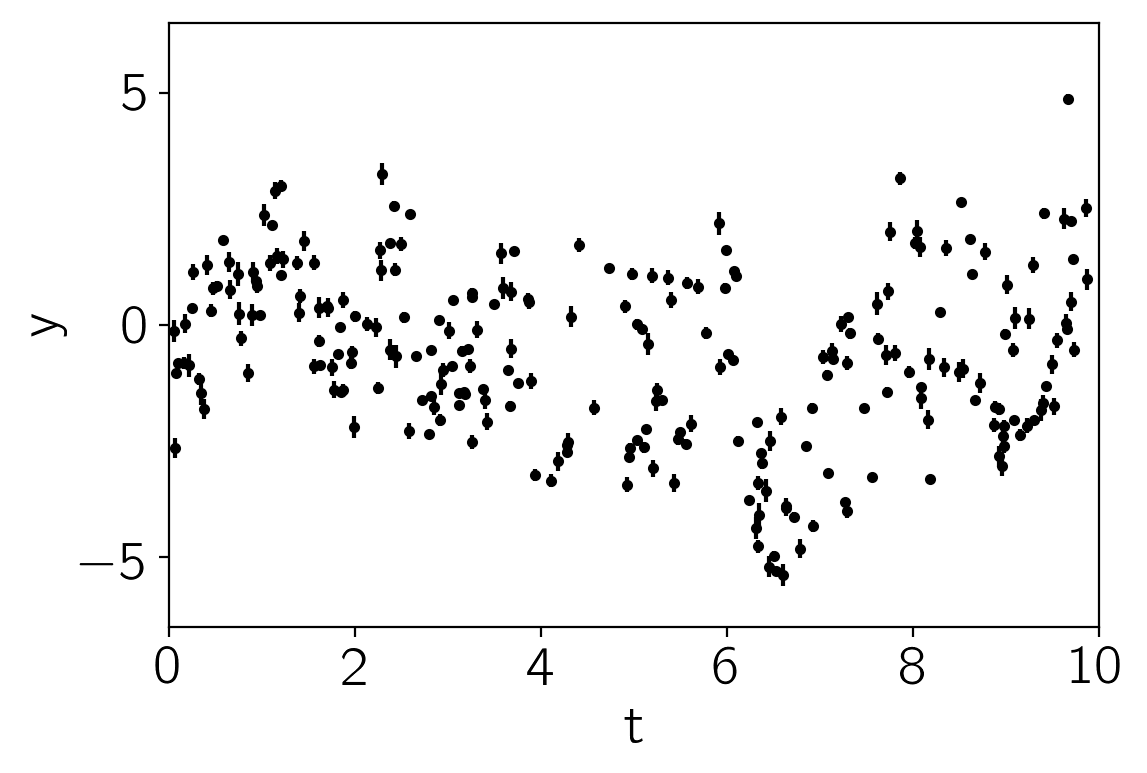

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from george import kernels

np.random.seed(42)
N = 256
t = np.sort(np.random.uniform(0, 10, N))
theta = np.random.uniform(-np.pi, np.pi, N)
X = np.vstack((t, theta)).T
yerr = np.random.uniform(0.05, 0.25, N)

kernel1 = 2.0 * kernels.Matern32Kernel([5.0, 0.5], ndim=2)
kernel2 = 2.0 * kernels.ExpSine2Kernel(gamma=10.0, log_period=np.log(5.), ndim=2, axes=0)
kernel2 *= kernels.ExpSquaredKernel([15.0], ndim=2, axes=0)
kernel = kernel1 + kernel2

gp = george.GP(kernel)
y = gp.sample(X)
y += yerr * np.random.randn(N)
gp.compute(X, yerr)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.ylim(-6.5, 6.5)
plt.xlim(0, 10)
plt.xlabel("t")
plt.ylabel("y");

The physical (oscillatory) component is not obvious in this dataset because it is swamped by the systematics.
Now, we'll find the maximum likelihood hyperparameters by numerically minimizing the negative log-likelihood function.

In [4]:
from scipy.optimize import minimize

def nll(params):
    gp.set_parameter_vector(params)
    l = gp.log_likelihood(y, quiet=True)
    g = gp.grad_log_likelihood(y, quiet=True)
    return -l, -g

params = gp.get_parameter_vector()
params += 0.05*np.random.randn(len(params))
soln = minimize(nll, params, jac=True)
gp.set_parameter_vector(soln.x)
print(soln.success, soln.x)

True [  0.38315985   1.88867446  -0.35673864  -0.33250025  11.98452994
   1.59429178   2.11371316]


Now let's use the trick from above to compute the prediction of component 1 and remove it to see the periodic signal.

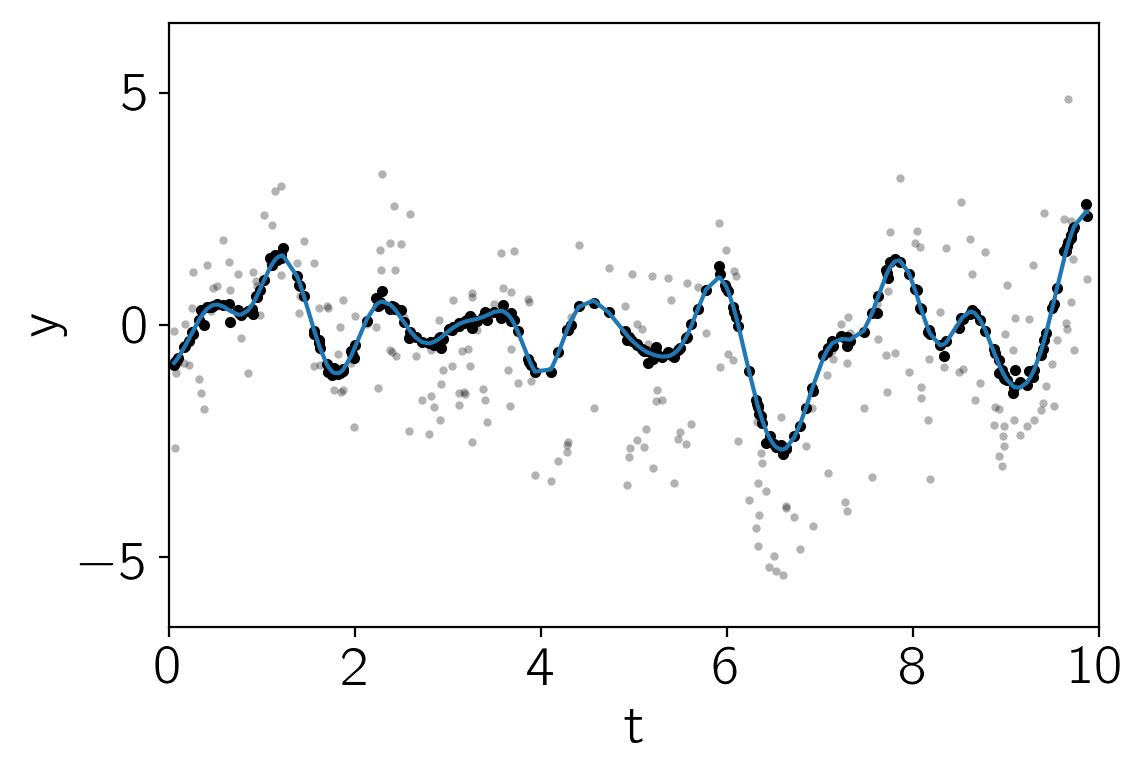

In [5]:
# Compute the predictive means - note the "kernel" argument
mu1 = gp.predict(y, X, return_cov=False, kernel=kernel1)
mu2 = gp.predict(y, X, return_cov=False, kernel=kernel2)

plt.plot(t, y, ".k", mec="none", alpha=0.3)
plt.plot(t, y - mu1, ".k")
plt.plot(t, mu2)

plt.ylim(-6.5, 6.5)
plt.xlim(0, 10)
plt.xlabel("t")
plt.ylabel("y");

In this plot, the original dataset is plotted in light gray points and the "de-trended" data with component 1 removed is plotted as black points.
The prediction of the GP model for component 2 is shown as a blue line.